# SRCNN - 2x

## Imports

In [ ]:
import os
import zipfile

In [ ]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize
from tqdm import tqdm
from PIL import Image

In [ ]:
print(torch.__version__)

2.4.0+cu121


## SRCNN Architecture (2x)

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)

    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

## Download the dataset

In [ ]:
def download_div2k_dataset(output_dir):
    os.makedirs(output_dir, exist_ok=True)
    urls = {
        'train': 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip',
        'valid': 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'
    }

    for dataset_type, url in urls.items():
        output_path = os.path.join(output_dir, f'DIV2K_{dataset_type}_HR.zip')

        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(output_path, 'wb') as file, tqdm(
            desc=f'{dataset_type.capitalize()} Dataset',
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as progress_bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                progress_bar.update(size)

        with zipfile.ZipFile(output_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)

        os.remove(output_path)

    print("Dataset downloaded and extracted successfully.")
    return os.path.join(output_dir, 'DIV2K_train_HR'), os.path.join(output_dir, 'DIV2K_valid_HR')

## Custom Dataset

In [ ]:
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, scale_factor=2, lr_size=(128, 128), transform=None):
        self.hr_dir = hr_dir
        self.scale_factor = scale_factor
        self.lr_size = lr_size
        self.hr_size = (lr_size[0] * scale_factor, lr_size[1] * scale_factor)
        self.transform = transform
        self.image_files = [f for f in os.listdir(hr_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.hr_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        lr_image = image.resize(self.lr_size, Image.BICUBIC)

        hr_image = image.resize(self.hr_size, Image.BICUBIC)

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

## Dataloaders

In [ ]:
def create_dataloaders(train_dir, val_dir, batch_size=16):
    transform = transforms.Compose([
        ToTensor(),
    ])

    train_dataset = DIV2KDataset(train_dir, scale_factor=2, lr_size=(128, 128), transform=transform)
    val_dataset = DIV2KDataset(val_dir, scale_factor=2, lr_size=(128, 128), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader

## Train function

In [ ]:
def train_srcnn(model, train_loader, val_loader, num_epochs, learning_rate, device):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for low_res, high_res in train_pbar:
            low_res, high_res = low_res.to(device), high_res.to(device)

            optimizer.zero_grad()
            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{train_loss/len(train_loader):.4f}'})

        model.eval()
        val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        with torch.no_grad():
            for low_res, high_res in val_pbar:
                low_res, high_res = low_res.to(device), high_res.to(device)

                outputs = model(low_res)
                loss = criterion(outputs, high_res)
                val_loss += loss.item()
                val_pbar.set_postfix({'loss': f'{val_loss/len(val_loader):.4f}'})

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    return model

## Testing

In [ ]:
def test_srcnn(model, image_path, device):
    model = model.to(device)
    model.eval()

    transform = transforms.Compose([
        ToTensor(),
    ])

    img = Image.open(image_path).convert('RGB')

    low_res_img = img.resize((img.width // 2, img.height // 2), Image.BICUBIC)

    img_tensor = transform(low_res_img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)

    super_res_img = transforms.ToPILImage()(output.squeeze().cpu())

    low_res_shape = low_res_img.size
    super_res_shape = super_res_img.size

    return low_res_img, super_res_img, low_res_shape, super_res_shape

## Main execution

In [ ]:
# set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# set the directory for the dataset in Colab
dataset_dir = "DIV2K_dataset"

In [ ]:
train_dir, val_dir = download_div2k_dataset(dataset_dir)

Train Dataset: 100%|██████████| 3.29G/3.29G [02:26<00:00, 24.0MiB/s]
Valid Dataset: 100%|██████████| 428M/428M [00:15<00:00, 29.3MiB/s]


Dataset downloaded and extracted successfully.


In [ ]:
# print directory information for debugging
print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Validation directory exists: {os.path.exists(val_dir)}")
print(f"Contents of train directory: {os.listdir(train_dir)[:5]}")
print(f"Contents of validation directory: {os.listdir(val_dir)[:5]}")

Train directory: DIV2K_dataset/DIV2K_train_HR
Validation directory: DIV2K_dataset/DIV2K_valid_HR
Train directory exists: True
Validation directory exists: True
Contents of train directory: ['0391.png', '0011.png', '0144.png', '0643.png', '0039.png']
Contents of validation directory: ['0869.png', '0875.png', '0822.png', '0882.png', '0813.png']


In [ ]:
train_loader, val_loader = create_dataloaders(train_dir, val_dir)

In [ ]:
model = SRCNN()

In [ ]:
# hyperparameters
num_epochs = 50
learning_rate = 0.001

In [ ]:
trained_model = train_srcnn(model, train_loader, val_loader, num_epochs, learning_rate, device)

Epoch 1/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it, loss=0.0099]


Epoch [1/50], Train Loss: 0.0280, Val Loss: 0.0099


Epoch 2/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.57s/it, loss=0.0062]


Epoch [2/50], Train Loss: 0.0073, Val Loss: 0.0062


Epoch 3/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.44s/it, loss=0.0049]


Epoch [3/50], Train Loss: 0.0052, Val Loss: 0.0049


Epoch 4/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.36s/it, loss=0.0043]


Epoch [4/50], Train Loss: 0.0051, Val Loss: 0.0043


Epoch 5/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.36s/it, loss=0.0038]


Epoch [5/50], Train Loss: 0.0041, Val Loss: 0.0038


Epoch 6/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.33s/it, loss=0.0035]


Epoch [6/50], Train Loss: 0.0035, Val Loss: 0.0035


Epoch 7/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.39s/it, loss=0.0036]


Epoch [7/50], Train Loss: 0.0033, Val Loss: 0.0036


Epoch 8/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.55s/it, loss=0.0031]


Epoch [8/50], Train Loss: 0.0033, Val Loss: 0.0031


Epoch 9/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.46s/it, loss=0.0029]


Epoch [9/50], Train Loss: 0.0029, Val Loss: 0.0029


Epoch 10/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.34s/it, loss=0.0028]


Epoch [10/50], Train Loss: 0.0029, Val Loss: 0.0028


Epoch 11/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.34s/it, loss=0.0029]


Epoch [11/50], Train Loss: 0.0027, Val Loss: 0.0029


Epoch 12/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.36s/it, loss=0.0026]


Epoch [12/50], Train Loss: 0.0027, Val Loss: 0.0026


Epoch 13/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.39s/it, loss=0.0025]


Epoch [13/50], Train Loss: 0.0025, Val Loss: 0.0025


Epoch 14/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.42s/it, loss=0.0025]


Epoch [14/50], Train Loss: 0.0025, Val Loss: 0.0025


Epoch 15/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.47s/it, loss=0.0024]


Epoch [15/50], Train Loss: 0.0025, Val Loss: 0.0024


Epoch 16/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.48s/it, loss=0.0026]


Epoch [16/50], Train Loss: 0.0030, Val Loss: 0.0026


Epoch 17/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.47s/it, loss=0.0027]


Epoch [17/50], Train Loss: 0.0025, Val Loss: 0.0027


Epoch 18/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.46s/it, loss=0.0024]


Epoch [18/50], Train Loss: 0.0024, Val Loss: 0.0024


Epoch 19/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.47s/it, loss=0.0023]


Epoch [19/50], Train Loss: 0.0023, Val Loss: 0.0023


Epoch 20/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.49s/it, loss=0.0023]


Epoch [20/50], Train Loss: 0.0023, Val Loss: 0.0023


Epoch 21/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.46s/it, loss=0.0023]


Epoch [21/50], Train Loss: 0.0023, Val Loss: 0.0023


Epoch 22/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.43s/it, loss=0.0024]


Epoch [22/50], Train Loss: 0.0023, Val Loss: 0.0024


Epoch 23/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.42s/it, loss=0.0022]


Epoch [23/50], Train Loss: 0.0022, Val Loss: 0.0022


Epoch 24/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.38s/it, loss=0.0022]


Epoch [24/50], Train Loss: 0.0022, Val Loss: 0.0022


Epoch 25/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.39s/it, loss=0.0022]


Epoch [25/50], Train Loss: 0.0022, Val Loss: 0.0022


Epoch 26/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it, loss=0.0022]


Epoch [26/50], Train Loss: 0.0021, Val Loss: 0.0022


Epoch 27/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.36s/it, loss=0.0022]


Epoch [27/50], Train Loss: 0.0022, Val Loss: 0.0022


Epoch 28/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.33s/it, loss=0.0026]


Epoch [28/50], Train Loss: 0.0022, Val Loss: 0.0026


Epoch 29/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.35s/it, loss=0.0021]


Epoch [29/50], Train Loss: 0.0022, Val Loss: 0.0021


Epoch 30/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it, loss=0.0022]


Epoch [30/50], Train Loss: 0.0021, Val Loss: 0.0022


Epoch 31/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.34s/it, loss=0.0022]


Epoch [31/50], Train Loss: 0.0025, Val Loss: 0.0022


Epoch 32/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it, loss=0.0021]


Epoch [32/50], Train Loss: 0.0021, Val Loss: 0.0021


Epoch 33/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.34s/it, loss=0.0021]


Epoch [33/50], Train Loss: 0.0021, Val Loss: 0.0021


Epoch 34/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.36s/it, loss=0.0021]


Epoch [34/50], Train Loss: 0.0021, Val Loss: 0.0021


Epoch 35/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it, loss=0.0021]


Epoch [35/50], Train Loss: 0.0021, Val Loss: 0.0021


Epoch 36/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.35s/it, loss=0.0021]


Epoch [36/50], Train Loss: 0.0022, Val Loss: 0.0021


Epoch 37/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.35s/it, loss=0.0021]


Epoch [37/50], Train Loss: 0.0020, Val Loss: 0.0021


Epoch 38/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.33s/it, loss=0.0021]


Epoch [38/50], Train Loss: 0.0021, Val Loss: 0.0021


Epoch 39/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.32s/it, loss=0.0021]


Epoch [39/50], Train Loss: 0.0020, Val Loss: 0.0021


Epoch 40/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.30s/it, loss=0.0020]


Epoch [40/50], Train Loss: 0.0020, Val Loss: 0.0020


Epoch 41/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.35s/it, loss=0.0021]


Epoch [41/50], Train Loss: 0.0020, Val Loss: 0.0021


Epoch 42/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.43s/it, loss=0.0022]


Epoch [42/50], Train Loss: 0.0025, Val Loss: 0.0022


Epoch 43/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.42s/it, loss=0.0020]


Epoch [43/50], Train Loss: 0.0021, Val Loss: 0.0020


Epoch 44/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.41s/it, loss=0.0021]


Epoch [44/50], Train Loss: 0.0020, Val Loss: 0.0021


Epoch 45/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.29s/it, loss=0.0022]


Epoch [45/50], Train Loss: 0.0022, Val Loss: 0.0022


Epoch 46/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.38s/it, loss=0.0020]


Epoch [46/50], Train Loss: 0.0020, Val Loss: 0.0020


Epoch 47/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.32s/it, loss=0.0020]


Epoch [47/50], Train Loss: 0.0020, Val Loss: 0.0020


Epoch 48/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.36s/it, loss=0.0020]


Epoch [48/50], Train Loss: 0.0020, Val Loss: 0.0020


Epoch 49/50 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.49s/it, loss=0.0020]


Epoch [49/50], Train Loss: 0.0020, Val Loss: 0.0020


Epoch 50/50 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.39s/it, loss=0.0020]

Epoch [50/50], Train Loss: 0.0020, Val Loss: 0.0020


## Saving the model

In [ ]:
# save the trained model
torch.save(trained_model.state_dict(), "srcnn_model_2x.pth")

## Load the model

In [ ]:
def load_srcnn_model(model_path, device):
    model = SRCNN()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")

    return model

In [ ]:
model = load_srcnn_model("srcnn_model_2x.pth", device)

Model loaded from srcnn_model_4x.pth


<ipython-input-58-bb91f0b7c842>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


## Image comparison

In [ ]:
# test the model on a new image
test_image_path = "quartlenna.png"
low_res_img, super_res_img, low_res_shape, super_res_shape = test_srcnn(model, test_image_path, device)

In [ ]:
def display_images(img1, img2, shape1, shape2, title1="Original", title2="Super-Resolved"):
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(img1)
    plt.title(f"{title1}\nShape: {shape1[0]}x{shape1[1]}")
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(img2)
    plt.title(f"{title2}\nShape: {shape2[0]}x{shape2[1]}")
    plt.axis('off')
    plt.show()

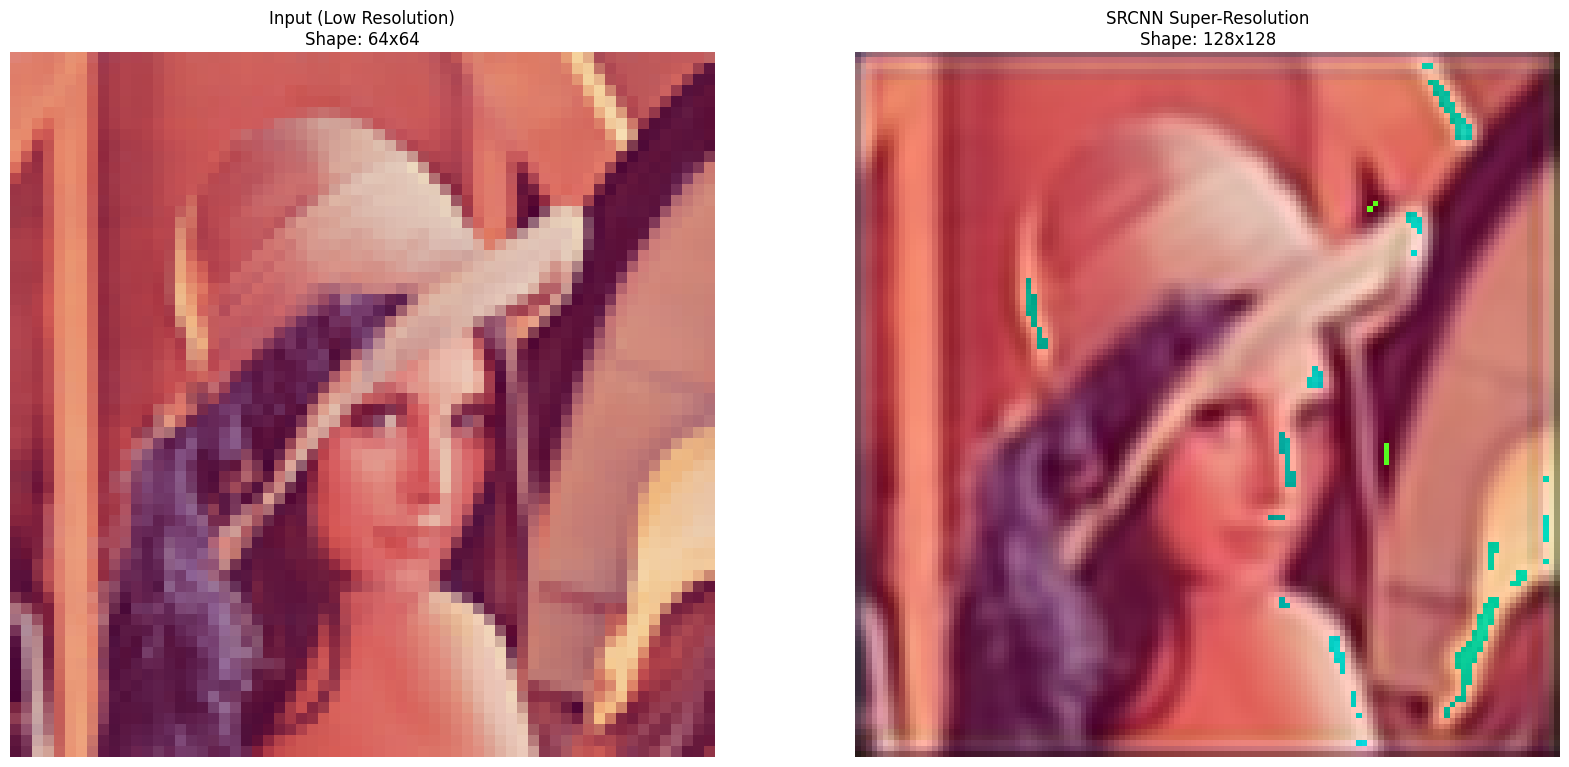

In [ ]:
display_images(low_res_img, super_res_img, low_res_shape, super_res_shape,
                "Input (Low Resolution)", "SRCNN Super-Resolution")

## Conclusion

Due to the simplicity of the SRCNN's architecture the *edge artifacts* are visible.